## Библиотеки

In [1]:
import pandas as pd
import numpy as np
import requests
import io
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
from sklearn.decomposition import PCA

In [58]:
# df = pd.read_csv('rates.csv', encoding='cp1251', sep=';', header=0)
# df.head()

## Загрузка данных

In [2]:
bond_url = 'https://iss.moex.com/iss/apps/infogrid/emission/rates.csv?iss.dp=comma&iss.df=%25d.%25m.%25Y&iss.tf=%25H:%25M:%25S&iss.dtf=%25d.%25m.%25Y%25H:%25M:%25S&iss.only=rates&limit=unlimited&lang=ru'
s = requests.get(bond_url).content
df = pd.read_csv(io.StringIO(s.decode('cp1251')), sep=';', header=1)
df.head()

,SECID,SHORTNAME,NAME,TYPENAME,ISIN,REGNUMBER,LISTLEVEL,FACEVALUE,FACEUNIT,ISSUESIZE,...,RTL3,RTH3,DISCOUNT1,LIMIT1,DISCOUNT2,LIMIT2,DISCOUNT3,DISCOUNTL0,DISCOUNTH0,FULLCOVERED
0,AMUNIBB2AER2,UBANK11/22,UNIBANK OJSC Series 1,Корпоративные еврооблигации,AMUNIBB2AER2,NaN,3.0,"100,0",USD,10000.0,...,"0,0","13420,22","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
1,AMUNIBB2DER6,UBANK02/24,UNIBANK OJSC Series 1 21,Корпоративные еврооблигации,AMUNIBB2DER6,NaN,3.0,"100,0",USD,33478.0,...,"0,0","13583,24","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
2,AT0000A2UF10,Raiff CAG,Raiffeisen Centrobank AG,Корпоративные еврооблигации,AT0000A2UF10,NaN,3.0,"1000,0",USD,50000.0,...,"0,0","111690,14","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
3,CH0248531110,VTB-24 CHF,VTB CAPITAL S.A. 24 CHF,Корпоративные еврооблигации,CH0248531110,NaN,NaN,"5000,0",CHF,70000.0,...,"0,0","759185,2","100,0",NaN,NaN,NaN,NaN,"100,00000","100,00000",1.0
4,CH0374882816,GAZ-22 CHF,GAZ CAPITAL SA 2.25 19/07/22,Корпоративные еврооблигации,CH0374882816,NaN,NaN,"5000,0",CHF,100000.0,...,"231848,38","347772,58","14,0",2000.0,"17,0",10000.0,"20,0","14,00000","14,00000",1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 54 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SECID                   2666 non-null   object 
 1   SHORTNAME               2666 non-null   object 
 2   NAME                    2666 non-null   object 
 3   TYPENAME                2666 non-null   object 
 4   ISIN                    2666 non-null   object 
 5   REGNUMBER               2274 non-null   object 
 6   LISTLEVEL               2410 non-null   float64
 7   FACEVALUE               2666 non-null   object 
 8   FACEUNIT                2666 non-null   object 
 9   ISSUESIZE               2650 non-null   float64
 10  IS_COLLATERAL           2666 non-null   int64  
 11  IS_EXTERNAL             2666 non-null   int64  
 12  PRIMARY_BOARDID         2666 non-null   object 
 13  PRIMARY_BOARD_TITLE     2666 non-null   object 
 14  MATDATE                 2615 non-null   

#### 1. Оценить рынок рублевых облигаций по распределению купонной доходности, предложить разделение на кластеры по купонной доходности. Предложить графическое представление полученных групп/кластеров. (график)

In [4]:
# отбираем только рублевые облигации, код ценбум начинается с RU

rub_bonds = df[df['SECID'].str.match('^RU')][df['FACEUNIT'] == 'RUB'].copy(deep=True)
len(rub_bonds)

C:\Users\anna_\AppData\Local\Temp/ipykernel_772/2815018831.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rub_bonds = df[df['SECID'].str.match('^RU')][df['FACEUNIT'] == 'RUB'].copy(deep=True)


2174

### Дубликаты

In [5]:
rub_bonds.duplicated().sum()

0

### Пропущенные значения

In [6]:
rub_bonds.isna().sum()

SECID                        0
SHORTNAME                    0
NAME                         0
TYPENAME                     0
ISIN                         0
REGNUMBER                   28
LISTLEVEL                  145
FACEVALUE                    0
FACEUNIT                     0
ISSUESIZE                   15
IS_COLLATERAL                0
IS_EXTERNAL                  0
PRIMARY_BOARDID              0
PRIMARY_BOARD_TITLE          0
MATDATE                     29
IS_RII                    2162
EVENINGSESSION               0
MORNINGSESSION               0
DURATION                   739
IS_QUALIFIED_INVESTORS       0
HIGH_RISK                    0
COUPONFREQUENCY            335
YIELDATWAP                1184
COUPONDATE                   4
COUPONPERCENT               37
COUPONVALUE                 35
COUPONDAYSPASSED             4
COUPONDAYSREMAIN             4
COUPONLENGTH                 4
ISSUEDATE                  145
INITIALFACEVALUE             0
SECSUBTYPE                2069
STARTDAT

### Удаление столбцов, не участвующих в расчете купонной доходности

In [7]:
rub_bonds.drop(columns=['TYPENAME', 'ISIN', 'REGNUMBER', 'LISTLEVEL', 'IS_COLLATERAL', 'IS_EXTERNAL', 'PRIMARY_BOARDID', 'PRIMARY_BOARD_TITLE', 
                        'DURATION', 'EVENINGSESSION', 'MORNINGSESSION', 'YIELDATWAP', 'INITIALFACEVALUE', 'SECSUBTYPE', 'STARTDATEMOEX',
                        'LOTSIZE', 'RTL1', 'RTH1', 'RTL2', 'RTH2', 'RTL3', 'RTH3', 'DISCOUNT1', 'LIMIT1', 'IS_RII',
                        'DISCOUNT2', 'LIMIT2', 'DISCOUNT3', 'DISCOUNTL0', 'DISCOUNTH0', 'FULLCOVERED', 'OFFERDATE'], inplace=True)

### Удаление строк с NaN-значениями в определенных колонках

In [8]:
# NaN-значение в столбце PRICE означает, что в текущую дату не было сделок на Мосбирже

rub_bonds.dropna(subset=['COUPONPERCENT', 'COUPONDAYSPASSED', 'PRICE', 'PRICE_RUB'], inplace=True)

### Преобразование типов данных

In [9]:
rub_bonds['FACEVALUE'] = pd.to_numeric(rub_bonds['FACEVALUE'].str.replace(',', '.')).astype(int)              

In [10]:
rub_bonds['MATDATE'] = pd.to_datetime(rub_bonds['MATDATE'], format='%d.%m.%Y')
rub_bonds['COUPONDATE'] = pd.to_datetime(rub_bonds['COUPONDATE'], format='%d.%m.%Y')
rub_bonds['ISSUEDATE'] = pd.to_datetime(rub_bonds['ISSUEDATE'], format='%d.%m.%Y')

In [11]:
rub_bonds['COUPONPERCENT'] = pd.to_numeric(rub_bonds['COUPONPERCENT'].str.replace(',', '.'))
rub_bonds['COUPONVALUE'] = pd.to_numeric(rub_bonds['COUPONVALUE'].str.replace(',', '.'))

In [12]:
rub_bonds['ISSUESIZE'] = rub_bonds['ISSUESIZE'].astype(int)
rub_bonds['COUPONDAYSPASSED'] = rub_bonds['COUPONDAYSPASSED'].astype(int)
rub_bonds['COUPONDAYSREMAIN'] = rub_bonds['COUPONDAYSREMAIN'].astype(int)
rub_bonds['COUPONLENGTH'] = rub_bonds['COUPONLENGTH'].astype(int)
rub_bonds['COUPONFREQUENCY'] = rub_bonds['COUPONFREQUENCY'].astype(float).astype('Int64')
rub_bonds['DAYSTOREDEMPTION'] = rub_bonds['DAYSTOREDEMPTION'].astype(float).astype('Int64')

In [13]:
rub_bonds['INN'] = rub_bonds['INN'].fillna(0).map('{:.0f}'.format).astype(str)

In [14]:
rub_bonds['PRICE'] = pd.to_numeric(rub_bonds['PRICE'].str.replace(',', '.'))
rub_bonds['PRICE_RUB'] = pd.to_numeric(rub_bonds['PRICE_RUB'].str.replace(',', '.'))

In [15]:
rub_bonds.tail(3)

,SECID,SHORTNAME,NAME,FACEVALUE,FACEUNIT,ISSUESIZE,MATDATE,IS_QUALIFIED_INVESTORS,HIGH_RISK,COUPONFREQUENCY,...,COUPONVALUE,COUPONDAYSPASSED,COUPONDAYSREMAIN,COUPONLENGTH,ISSUEDATE,DAYSTOREDEMPTION,EMITENTNAME,INN,PRICE,PRICE_RUB
2244,RU000A104TM1,ХайТэк 01,Хайтэк-Интеграция БО-01,1000,RUB,150000,2025-05-15,0,0,4,...,59.84,11,80,91,2022-05-19,1081,"Общество с ограниченной ответственностью ""Хайт...",7722350688,99.97,1006.93
2246,RU000A104U68,ИНГРАД 2P3,ИНГРАД 002P-03,1000,RUB,10000000,2032-05-14,0,0,2,...,76.34,3,179,182,2022-05-27,3637,"Публичное акционерное общество ""ИНГРАД""",7702336269,100.00,1001.26
2248,RU000A104UA4,Сегежа2P4R,ГК Сегежа 002P-04R,1000,RUB,7000000,2037-05-11,0,0,4,...,27.42,0,91,91,2022-05-30,5460,Публичное акционерное общество Группа компаний...,9703024202,100.00,1000.00


In [16]:
rub_bonds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1991 entries, 13 to 2248
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   SECID                   1991 non-null   object        
 1   SHORTNAME               1991 non-null   object        
 2   NAME                    1991 non-null   object        
 3   FACEVALUE               1991 non-null   int32         
 4   FACEUNIT                1991 non-null   object        
 5   ISSUESIZE               1991 non-null   int32         
 6   MATDATE                 1962 non-null   datetime64[ns]
 7   IS_QUALIFIED_INVESTORS  1991 non-null   int64         
 8   HIGH_RISK               1991 non-null   int64         
 9   COUPONFREQUENCY         1668 non-null   Int64         
 10  COUPONDATE              1991 non-null   datetime64[ns]
 11  COUPONPERCENT           1991 non-null   float64       
 12  COUPONVALUE             1991 non-null   float64

## Данные для расчетов

In [17]:
# Добавим текущую дату в таблицу

rub_bonds['current_date'] = datetime.date.today()
rub_bonds.head(2)

,SECID,SHORTNAME,NAME,FACEVALUE,FACEUNIT,ISSUESIZE,MATDATE,IS_QUALIFIED_INVESTORS,HIGH_RISK,COUPONFREQUENCY,...,COUPONDAYSPASSED,COUPONDAYSREMAIN,COUPONLENGTH,ISSUEDATE,DAYSTOREDEMPTION,EMITENTNAME,INN,PRICE,PRICE_RUB,current_date
13,RU000A0JNYN1,МГор48-об,Гор.Обл.Займ Москвы 48 в.,1000,RUB,30000000,2022-06-11,0,0,2,...,170,12,182,2006-12-11,12,Правительство Москвы,7710152113,99.76,1025.55,2022-05-30
14,RU000A0JQ5C5,НПФ 01,"""НПФ"" ООО об.сер. 01",1000,RUB,40800,2029-05-06,0,1,<NA>,...,4771,2533,7304,2009-05-07,2533,"Общество с ограниченной ответственностью ""Недв...",6658196868,100.00,1653.56,2022-05-30


In [18]:
# Период расчета доходности рекомендуется выбирать 365 дней (1 год) с текущей даты
period = 365
years = 1

# НДФЛ 13%
NDFL = 0.87

# комиссия брокера 0.06%
broker_commission = 0.06 / 100

# комиссия Биржи 0,0125%
moex_commission = 0.0125 / 100

# цена покупки
price = rub_bonds['PRICE'] * rub_bonds['FACEVALUE'] / 100

# купонный доход, руб.
KD = rub_bonds['FACEVALUE'] * rub_bonds['COUPONPERCENT'] / 100

### Расчет НКД

In [19]:
# Накопленный купонный доход в % рассчитывается как произведение ставки купона на кол-во дней с момента последней даты
# выплаты купона, деленное на 365 дней.
# Для расчета НКД в рублях умножаем на номинальную стоимость облигации и делим на 100%.

rub_bonds['NKD_RUB'] = (rub_bonds['COUPONPERCENT'] / 100 * rub_bonds['FACEVALUE']) * rub_bonds['COUPONDAYSPASSED'] / period
rub_bonds['NKD_RUB'] = rub_bonds['NKD_RUB'].round(2)

In [20]:
rub_bonds.tail(3)

,SECID,SHORTNAME,NAME,FACEVALUE,FACEUNIT,ISSUESIZE,MATDATE,IS_QUALIFIED_INVESTORS,HIGH_RISK,COUPONFREQUENCY,...,COUPONDAYSREMAIN,COUPONLENGTH,ISSUEDATE,DAYSTOREDEMPTION,EMITENTNAME,INN,PRICE,PRICE_RUB,current_date,NKD_RUB
2244,RU000A104TM1,ХайТэк 01,Хайтэк-Интеграция БО-01,1000,RUB,150000,2025-05-15,0,0,4,...,80,91,2022-05-19,1081,"Общество с ограниченной ответственностью ""Хайт...",7722350688,99.97,1006.93,2022-05-30,7.23
2246,RU000A104U68,ИНГРАД 2P3,ИНГРАД 002P-03,1000,RUB,10000000,2032-05-14,0,0,2,...,179,182,2022-05-27,3637,"Публичное акционерное общество ""ИНГРАД""",7702336269,100.00,1001.26,2022-05-30,1.26
2248,RU000A104UA4,Сегежа2P4R,ГК Сегежа 002P-04R,1000,RUB,7000000,2037-05-11,0,0,4,...,91,91,2022-05-30,5460,Публичное акционерное общество Группа компаний...,9703024202,100.00,1000.00,2022-05-30,0.00


### Расчет купонной доходности

\begin{equation} 
Profit =  \frac{((Цена_{номинальная} - Цена_{покупки}) * (1 ЕСЛИ <= 0 │ 0.87 ЕСЛИ > 0) – НКД + 0.87 * Купонный Доход_{руб} * X лет) * 100 %} {((Цена_{покупки} + НКД)*(1 + Комиссия Брокера в Процентах / 100 + Комиссия Биржи / 100))}
\end{equation}

In [55]:
# price + rub_bonds['NKD'] = rub_bonds['PRICE_RUB']

In [21]:
# результат в %

rub_bonds['profit'] = ((rub_bonds['FACEVALUE'] - price).apply(lambda x: x if x <= 0 else x * NDFL) - rub_bonds['NKD_RUB'] \
                       + NDFL * KD * years) * 100 / (rub_bonds['PRICE_RUB'] * (1 + broker_commission + moex_commission))
rub_bonds['profit'] = rub_bonds['profit'].round(2)

In [22]:
rub_bonds.tail()

,SECID,SHORTNAME,NAME,FACEVALUE,FACEUNIT,ISSUESIZE,MATDATE,IS_QUALIFIED_INVESTORS,HIGH_RISK,COUPONFREQUENCY,...,COUPONLENGTH,ISSUEDATE,DAYSTOREDEMPTION,EMITENTNAME,INN,PRICE,PRICE_RUB,current_date,NKD_RUB,profit
2242,RU000A104TD0,Ростел2P7R,Ростелеком ПАО 002P-07R,1000,RUB,5000000,2026-05-08,0,0,4,...,91,2022-05-13,1439,"Публичное акционерное общество ""Ростелеком""",7707049388,103.89,1044.37,2022-05-30,5.47,5.54
2243,RU000A104TG3,ЦР БО-01,Центр-резерв БО-01,1000,RUB,100000,2025-10-28,0,0,12,...,30,2022-05-17,1247,"Общество с ограниченной ответственностью ""Цент...",5612069520,100.50,1012.84,2022-05-30,7.84,17.62
2244,RU000A104TM1,ХайТэк 01,Хайтэк-Интеграция БО-01,1000,RUB,150000,2025-05-15,0,0,4,...,91,2022-05-19,1081,"Общество с ограниченной ответственностью ""Хайт...",7722350688,99.97,1006.93,2022-05-30,7.23,20.03
2246,RU000A104U68,ИНГРАД 2P3,ИНГРАД 002P-03,1000,RUB,10000000,2032-05-14,0,0,2,...,182,2022-05-27,3637,"Публичное акционерное общество ""ИНГРАД""",7702336269,100.00,1001.26,2022-05-30,1.26,13.17
2248,RU000A104UA4,Сегежа2P4R,ГК Сегежа 002P-04R,1000,RUB,7000000,2037-05-11,0,0,4,...,91,2022-05-30,5460,Публичное акционерное общество Группа компаний...,9703024202,100.00,1000.00,2022-05-30,0.00,9.56


### Сохранение DataFrame в csv-файл

In [23]:
# rub_bonds.to_csv('rub_bonds.csv', encoding='cp1251', sep=',', index=False)

## Метод локтя для определения количества кластеров

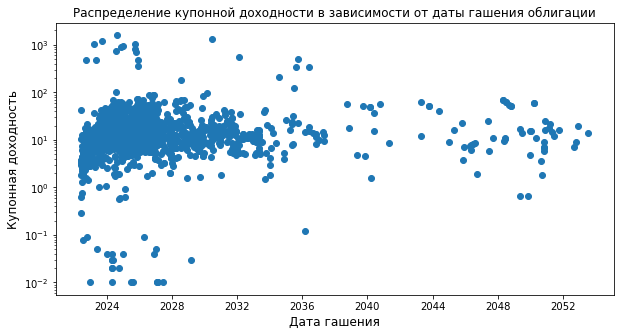

In [23]:
# визуализируем данные столбцов 'MATDATE', 'profit'

plt.figure(figsize=(10, 5))
plt.subplot()
plt.scatter(x=rub_bonds['MATDATE'], y=rub_bonds['profit'])
plt.yscale(value='log')
plt.title('Распределение купонной доходности в зависимости от даты гашения облигации')
plt.xlabel('Дата гашения', fontsize=12)
plt.ylabel('Купонная доходность', fontsize=12)
plt.show()

# Из визуализации можно предположить, что оптимальное количество кластеров должно быть 3-4.

In [24]:
# Создадим упрощенный датафрейм для расчета кол-ва кластеров, удалим столбцы с типам datetime, object, с NaN-значениями

rub_bonds_df_short = rub_bonds.drop(columns=['DAYSTOREDEMPTION', 'COUPONFREQUENCY', 'SECID', 'SHORTNAME', 'NAME', 'FACEUNIT', 'EMITENTNAME', 'MATDATE', 'COUPONDATE', 'ISSUEDATE', 'current_date'], axis=1) 

In [25]:
rub_bonds_df_short.isna().sum()

FACEVALUE                 0
ISSUESIZE                 0
IS_QUALIFIED_INVESTORS    0
HIGH_RISK                 0
COUPONPERCENT             0
COUPONVALUE               0
COUPONDAYSPASSED          0
COUPONDAYSREMAIN          0
COUPONLENGTH              0
INN                       0
PRICE                     0
PRICE_RUB                 0
NKD_RUB                   0
profit                    0
dtype: int64

In [26]:
# Повторяем алгоритм k-средних со значениями от k=2 до k=12 и вычисляем инерцию для каждого значения k в заданном диапазоне

inertias = []
K = range(2, 15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=123)
    kmeans.fit(rub_bonds_df_short)
    inertias.append(kmeans.inertia_)

In [27]:
inertias

[1.458019831999005e+21,
 5.664136291380316e+20,
 2.979141480859935e+20,
 1.911880001585721e+20,
 1.1634612180098141e+20,
 6.5167189094534545e+19,
 4.537217419594863e+19,
 3.275746687518704e+19,
 2.7648722662134735e+19,
 2.2805924549115486e+19,
 1.8086061475474119e+19,
 1.5178475018281353e+19,
 1.341554653260417e+19]

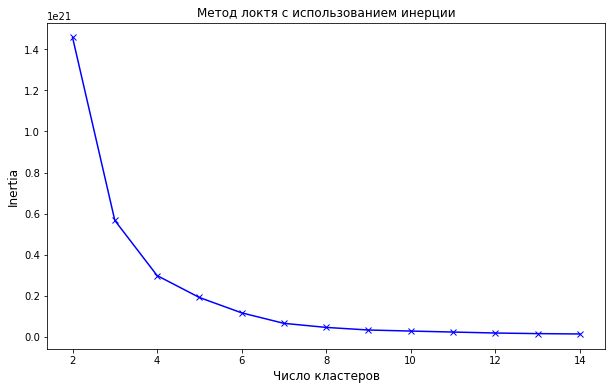

In [28]:
# Визуализация результатов

plt.figure(figsize =(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('Число кластеров', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Метод локтя с использованием инерции', fontsize=12)
plt.show()

# Чтобы определить оптимальное количество кластеров, мы должны выбрать значение k в «изгибе», то есть в точке, 
# после которой инерция начинает линейно уменьшаться. Таким образом, для заданных данных можно сделать вывод, 
# что оптимальное количество кластеров для данных - 3-4 .

## Silhouette Coefficient

In [29]:
scores = []
clusters = range(2, 15)
for i in clusters:
    labels = KMeans(n_clusters=i, random_state=123).fit(rub_bonds_df_short).labels_
    scores.append(metrics.silhouette_score(rub_bonds_df_short, labels, random_state=123))

In [30]:
sil_scores = pd.DataFrame({'кластеры': clusters, 'рейтинг': scores})
sil_scores

,кластеры,рейтинг
0,2,0.843751
1,3,0.857584
2,4,0.884971
3,5,0.877007
4,6,0.881668
5,7,0.889695
6,8,0.894954
7,9,0.896068
8,10,0.891381
9,11,0.889639


Text(0.5, 1.0, 'Коэффициент силуэта')

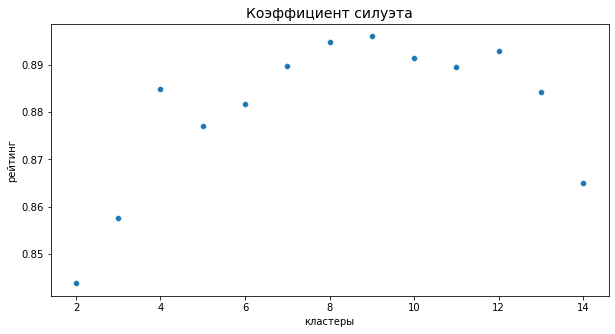

In [31]:
# Визуализация результатов

plt.figure(figsize=(10, 5))
sns.scatterplot(x='кластеры', y='рейтинг', data=sil_scores)
plt.title('Коэффициент силуэта', fontsize=14)

# График силуэта демонстрирует пик в точке 4, а также значения близки к единице в точках 8, 9 кластерных центров.

## PCA

In [32]:
# воспользуемся PCA для проецирования в двухмерное пространство и отображения данных и кластеров в этом новом пространстве

pca = PCA(2)

In [33]:
df_pca = pca.fit_transform(rub_bonds_df_short)

In [34]:
df_pca = pd.DataFrame(df_pca)

In [35]:
df_pca.columns = ['x1', 'x2']

Text(0.5, 1.0, 'Датафрейм с рублевыми облигациями в двухмерном пространстве')

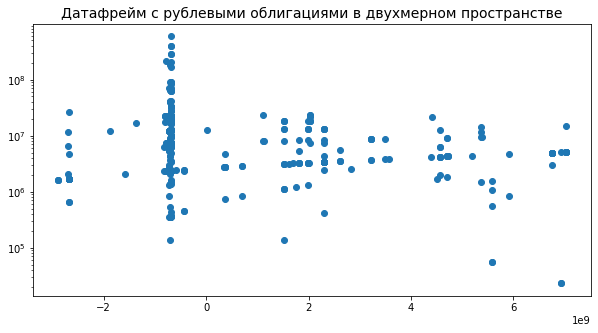

In [36]:
# отобразим на графике датафрейм, трансформированный в двухмерное пространство

plt.figure(figsize=(10, 5))
plt.scatter(df_pca.x1, df_pca.x2)
plt.yscale(value='log')
plt.title('Датафрейм с рублевыми облигациями в двухмерном пространстве', fontsize=14)

## Применение кластеризации KMeans

In [ ]:
# разобъем датафрейм на 3, 4 и 9 кластеров

In [37]:
kmeans = KMeans(n_clusters=3, random_state=123)
predict = kmeans.fit_predict(df_pca)
print(f'Silhouette Score(n=3): {metrics.silhouette_score(df_pca, predict)}') # считаем Silhouette Score

Silhouette Score(n=3): 0.8576473557009359


C:\Users\anna_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Данные, разбитые на 3 кластера')

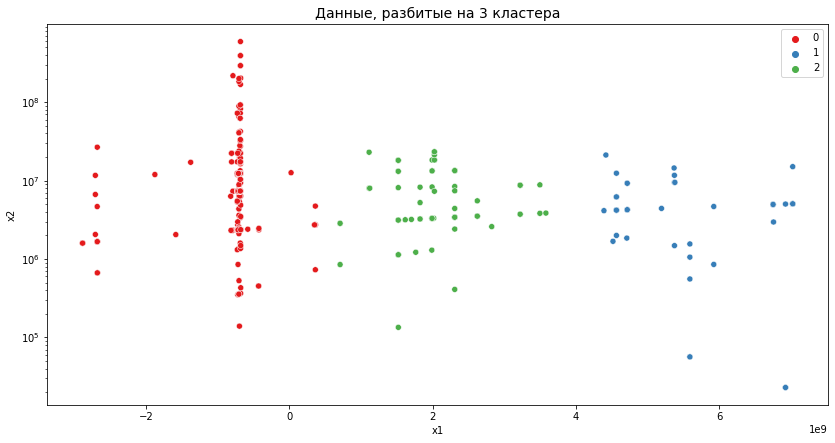

In [38]:
# Кластерные точки данных для значений k=3

plt.figure(figsize=(14, 7))
three_clusters = sns.scatterplot(df_pca['x1'], df_pca['x2'], hue=predict, palette='Set1')
three_clusters.set_yscale('log')
plt.title('Данные, разбитые на 3 кластера', fontsize=14)

In [39]:
kmeans = KMeans(n_clusters=4, random_state=123)
predict = kmeans.fit_predict(df_pca)
print(f'Silhouette Score(n=4): {metrics.silhouette_score(df_pca, predict)}') # считаем Silhouette Score

Silhouette Score(n=4): 0.8850538419760747


C:\Users\anna_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Данные, разбитые на 4 кластера')

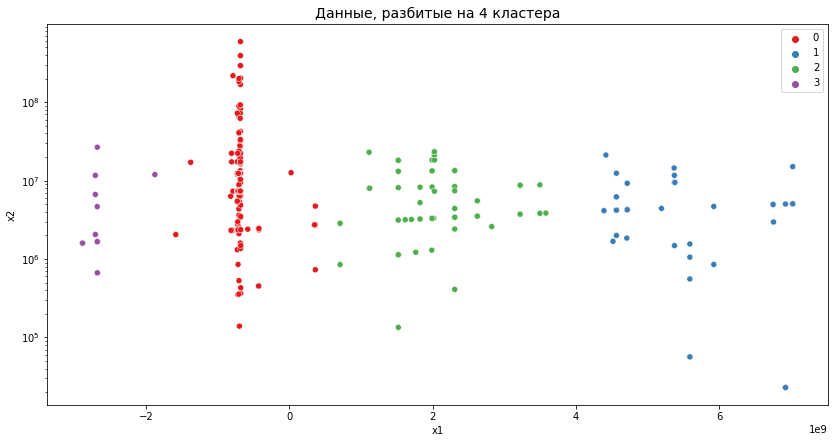

In [40]:
# Кластерные точки данных для значений k=4

plt.figure(figsize=(14, 7))
four_clusters = sns.scatterplot(df_pca['x1'], df_pca['x2'], hue=predict, palette='Set1')
four_clusters.set_yscale('log')
plt.title('Данные, разбитые на 4 кластера', fontsize=14)

In [41]:
kmeans = KMeans(n_clusters=9, random_state=123)
predict = kmeans.fit_predict(df_pca)
print(f'Silhouette Score(n=9): {metrics.silhouette_score(df_pca, predict)}') # считаем Silhouette Score

Silhouette Score(n=9): 0.8962195472336199


C:\Users\anna_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


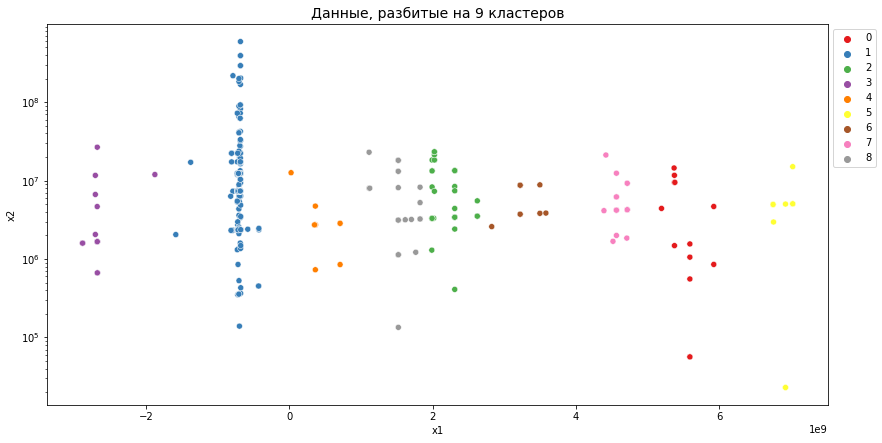

In [42]:
# Кластерные точки данных для значений k=9

plt.figure(figsize=(14, 7))
nine_clusters = sns.scatterplot(df_pca['x1'], df_pca['x2'], hue=predict, palette='Set1')
nine_clusters.set_yscale('log')
plt.title('Данные, разбитые на 9 кластеров', fontsize=14)
plt.legend(bbox_to_anchor=(1, 1))

In [ ]:
# Итак, можно сказать, что оптимальным количеством кластеров будет 9, так как силуэт оценка при k=9 равна 0.896, что выше, 
# чем оценка при k=3 или k=4.

##### 2. По низкорисковым рублевым облигациям с датой промежуточной выплаты по купонам не более 20% купонного периода назад до текущей даты и облигациям, выпущенных в аналогичный период, рассчитать доходность последующих купонов по отобранным облигациям с учетом разницы номинала и цены продажи, а также с учетом налоговых отчислений на период год с текущей даты. (график и/или таблица). 

In [43]:
# Отбираем низкорисковые рублевые облигации с датой промежуточной выплаты по купонам не более 20% 

rub_bonds['NKD_period_less_20'] = (rub_bonds['COUPONDAYSPASSED'] / rub_bonds['COUPONLENGTH']).round(2)
low_risk_bonds = rub_bonds.query('HIGH_RISK == 0 & NKD_period_less_20 <= 0.2')

In [44]:
# умножаем период расчета <= 0.2 на ставку купона, поделенную на число купонов в год. Тем самым получим ставку купона, 
# заработанную за период расчета не более 20%

low_risk_bonds['NKD_period_coupon'] = low_risk_bonds['NKD_period_less_20'] * low_risk_bonds['COUPONPERCENT'] / low_risk_bonds['COUPONFREQUENCY']

C:\Users\anna_\AppData\Local\Temp/ipykernel_772/167421286.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_risk_bonds['NKD_period_coupon'] = low_risk_bonds['NKD_period_less_20'] * low_risk_bonds['COUPONPERCENT'] / low_risk_bonds['COUPONFREQUENCY']


In [45]:
# Для расчета НКД в рублях умножаем на номинальную стоимость облигации и делим на 100%.

low_risk_bonds['NKD_period_less_20_RUB'] = (low_risk_bonds['NKD_period_coupon'] / 100 * low_risk_bonds['FACEVALUE']).round(2)

C:\Users\anna_\AppData\Local\Temp/ipykernel_772/3642636183.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_risk_bonds['NKD_period_less_20_RUB'] = (low_risk_bonds['NKD_period_coupon'] / 100 * low_risk_bonds['FACEVALUE']).round(2)


In [46]:
# цена покупки
price = low_risk_bonds['PRICE'] * low_risk_bonds['FACEVALUE'] / 100

# купонный доход, руб.
KD = low_risk_bonds['FACEVALUE'] * low_risk_bonds['COUPONPERCENT'] / 100

In [47]:
# Доходность низкоризковых рублевых облигаций за год, в %

low_risk_bonds['NKD_period_less_20_profit'] = ((low_risk_bonds['FACEVALUE'] - price).apply(lambda x: x if x <= 0 else x * NDFL) - low_risk_bonds['NKD_period_less_20_RUB'] + NDFL * KD * years) * 100 / \
                                            ((price + low_risk_bonds['NKD_period_less_20_RUB']) * (1 + broker_commission + moex_commission))
low_risk_bonds['NKD_period_less_20_profit'] = low_risk_bonds['NKD_period_less_20_profit'].round(2)

C:\Users\anna_\AppData\Local\Temp/ipykernel_772/314770322.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_risk_bonds['NKD_period_less_20_profit'] = ((low_risk_bonds['FACEVALUE'] - price).apply(lambda x: x if x <= 0 else x * NDFL) - low_risk_bonds['NKD_period_less_20_RUB'] + NDFL * KD * years) * 100 / \
C:\Users\anna_\AppData\Local\Temp/ipykernel_772/314770322.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_risk_bonds['NKD_period_less_20_profit'] = low_risk_bonds['NKD_period_less_20_profit'].

In [52]:
low_risk_bonds.head()

,SECID,SHORTNAME,NAME,FACEVALUE,FACEUNIT,ISSUESIZE,MATDATE,IS_QUALIFIED_INVESTORS,HIGH_RISK,COUPONFREQUENCY,...,INN,PRICE,PRICE_RUB,current_date,NKD_RUB,profit,NKD_period_less_20,NKD_period_coupon,NKD_period_less_20_RUB,NKD_period_less_20_profit
16,RU000A0JQAL8,ДОМ.РФ14об,ДОМ.РФ (АО) обл. сер. А14,1000,RUB,7000000,2023-05-15,0,0,2,...,7729355614,102.22,1028.98,2022-05-30,6.78,11.13,0.08,0.66,6.6,11.15
21,RU000A0JRJB8,ЗСД 01,Запад.скор.диаметр АО об.01,1000,RUB,5000000,2031-05-13,0,0,2,...,7825392577,131.95,1321.22,2022-05-30,1.72,-17.43,0.03,0.1566,1.57,-17.42
22,RU000A0JRJL7,ЗСД 02,Запад.скор.диаметр АО об.02,1000,RUB,5000000,2031-05-13,0,0,2,...,7825392577,99.81,999.82,2022-05-30,1.72,9.07,0.03,0.1566,1.57,9.09
65,RU000A0JTY57,РЖД БО-18,"""Российские ЖД"" ОАО БО-18",1000,RUB,25000000,2043-04-29,0,0,2,...,7708503727,67.74,679.82,2022-05-30,2.42,63.52,0.03,0.26535,2.65,63.47
66,RU000A0JTYJ6,ФСК ЕЭС-23,"""ФСК ЕЭС""(ПАО)-обл. сер.23",1000,RUB,10000000,2048-04-27,0,0,4,...,4716016979,66.64,666.40,2022-05-30,0.00,68.09,0.00,0.0,0.0,68.09


In [49]:
low_risk_bonds.isna().sum()

SECID                         0
SHORTNAME                     0
NAME                          0
FACEVALUE                     0
FACEUNIT                      0
ISSUESIZE                     0
MATDATE                       7
IS_QUALIFIED_INVESTORS        0
HIGH_RISK                     0
COUPONFREQUENCY              61
COUPONDATE                    0
COUPONPERCENT                 0
COUPONVALUE                   0
COUPONDAYSPASSED              0
COUPONDAYSREMAIN              0
COUPONLENGTH                  0
ISSUEDATE                     0
DAYSTOREDEMPTION              7
EMITENTNAME                   0
INN                           0
PRICE                         0
PRICE_RUB                     0
current_date                  0
NKD_RUB                       0
profit                        0
NKD_period_less_20            0
NKD_period_coupon            61
NKD_period_less_20_RUB       61
NKD_period_less_20_profit    61
dtype: int64

TypeError: float() argument must be a string or a number, not 'NAType'

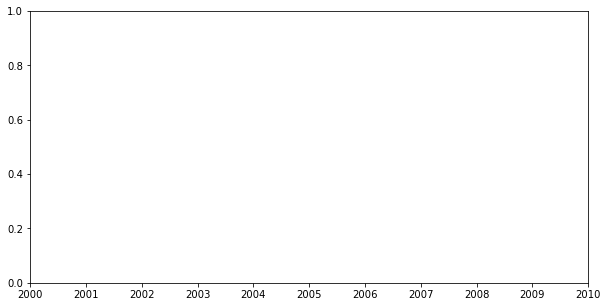

In [50]:
plt.figure(figsize=(10, 5))
plt.subplot()
plt.scatter(x=low_risk_bonds['MATDATE'], y=low_risk_bonds['NKD_period_less_20_profit'])
# plt.yscale(value='log')
plt.title('Купонная доходность низкорисковых рублевых облигаций в зависимости от даты гашения')
plt.xlabel('Дата гашения', fontsize=12)
plt.ylabel('Купонная доходность', fontsize=12)
plt.show()